Implementing a toy simulation for Bayesian A/B test with binary success metric.  

Context:  
- user-level randomization
- two groups
- imbalanced weights
- same user can have repeated measurements
- multiple aggregation levels
  - many reads a day
  - daily aggregation
  - cumulative aggregation over period

Examples of practical business metrics that match the case:
- conversions / purchases (converted or not converted, over all accesses)
- clicks (clicked or not, over impressions)
- refunds (refunded or not refunded)

# Imports and auxiliar functions

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import dblquad
import matplotlib.pyplot as plt

In [2]:
def bin_bayes_posterior_params(
    beta_0: float, 
    alpha_0: float,
    num_successes: int,
    num_trials: int):
    """Update the beta and alpha parameters for a binomial likelihood.
    Returns the posterior beta and alpha parameters.
    
    Prior is assumed to be a Beta distribution with parameters beta_0 and alpha_0.
    Likelihood is assumed to be a Binomial distribution with num_successes and num_trials.
    Because the Beta distribution is the conjugate prior to the Binomial distribution,
    the posterior is also a Beta distribution.
    
    beta_0: float, prior beta parameter
    alpha_0: float, prior alpha parameter
    """
    alpha = alpha_0 + num_successes
    beta = beta_0 + num_trials - num_successes  
    return alpha, beta


# calculate the confidence interval given the posterior distribution
def beta_credible_interval(alpha: float, beta: float, prob: float):
    """Calculate the credible interval for a Beta distribution.
    
    alpha: float, alpha parameter
    beta: float, beta parameter
    prob: float, probability for the credible interval
    """
    lower = stats.beta.ppf((1 - prob) / 2, alpha, beta)
    upper = stats.beta.ppf((1 + prob) / 2, alpha, beta)
    return lower, upper


def generate_daily_user_events(
    num_days: int,
    num_users: int,
    p_user_event: float,
    num_daily_sample_trials: int,
):
    """Generate daily user events. Returns a numpy array with the number of events per user per day."""
    
    return np.random.choice([0, 1], size=(num_users, num_days, num_daily_sample_trials), p=[1-p_user_event, p_user_event]).sum(axis=2)


def data_generation_process(
    start_date: str,
    end_date: str,
    num_users: int,
    num_daily_sample_trials: int,
    p_user_event: float,
    p_successful_event: float,
    seed: int = 0):
    """Data generation process for a binary event, intra-day."""
    
    num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    
    np.random.seed(seed)

    # Generate dates and users
    dates = pd.date_range(start=start_date, periods=num_days)
    user_ids = np.array([f"user_{i+1}" for i in range(num_users)])
    
    # output: users x days (rows x column), values: number of events per user per day
    num_events_per_user_per_day = generate_daily_user_events(
        num_days=num_days,
        num_users=num_users,
        p_user_event=p_user_event,
        num_daily_sample_trials=num_daily_sample_trials,
    )
    
    # For each event, generate a success/failure outcome
    total_events = num_events_per_user_per_day.sum()  # Total number of events across all users and days
    success_events = np.random.choice([0, 1], size=total_events, p=[1 - p_successful_event, p_successful_event])
    
    # Create arrays of user IDs, dates, and event IDs
    user_ids_repeated = np.repeat(user_ids, num_events_per_user_per_day.sum(axis=1))
    date_ids_repeated = np.repeat(np.tile(dates, num_users), num_events_per_user_per_day.flatten())
    
    # Flatten the number of events per user (total events for each user)
    events_per_user = num_events_per_user_per_day.sum(axis=1)

    # Step 1: Create event IDs
    # We want to reset the event ID for each user, so we create cumulative indices
    event_starts = np.cumsum(np.r_[0, events_per_user[:-1]])  # Starting indices for each user
    event_offsets = np.repeat(event_starts, events_per_user)  # Repeat these starting points

    # Step 2: Use np.arange to generate increasing event IDs and subtract the offsets
    event_ids = np.arange(1, events_per_user.sum() + 1) - event_offsets
        
    
    # Create DataFrame using vectorized data
    event_df = pd.DataFrame({
        "uuid": user_ids_repeated,
        "date": date_ids_repeated,
        "event_id": event_ids,
        "success": success_events
    })
    
    return event_df
    

# Simulation Parameters

In [3]:
start_date = "2021-01-01"
end_date = "2021-01-30"
num_daily_sessions_per_user = 1  # Number of daily sessions per user
p_user_daily_session_being_on_experiment = 1.  # probability that a user session is accounted for in the experiment; convertion samples are taken only on valid sessions

total_num_users = 100000
w_control = 0.5
w_treatment = 1 - w_control

true_p_success_control = 1.1e-2
beta_0_control = 1
alpha_0_control = 1

true_p_success_treatment = 1.2e-2
beta_0_treatment = 1
alpha_0_treatment = 1

baseline_seed = 0
treatment_seed_offset = 345678

ci_prob = 0.98

num_users_control = int(total_num_users * w_control)
num_users_treatment = total_num_users - num_users_control


loss_threshold = 0.1e-2  # a percentage of acceptable uplift loss in case we choose the wrong arm

# Generating Artificial data

We can get creative here in the future and try to account for multiple segments of users in each arm.  
They might have different conversion rates, appearance rates, weekly engagement, etc.  

In [4]:
df_control = data_generation_process(
    start_date=start_date,
    end_date=end_date,
    num_users=num_users_control,
    num_daily_sample_trials=num_daily_sessions_per_user,
    p_user_event=p_user_daily_session_being_on_experiment,
    p_successful_event=true_p_success_control,
    seed=baseline_seed)

df_treatment = data_generation_process(
    start_date=start_date,
    end_date=end_date,
    num_users=num_users_treatment,
    num_daily_sample_trials=num_daily_sessions_per_user,
    p_user_event=p_user_daily_session_being_on_experiment,
    p_successful_event=true_p_success_treatment,
    seed=baseline_seed + treatment_seed_offset)

In [5]:
df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450000 entries, 0 to 1449999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   uuid      1450000 non-null  object        
 1   date      1450000 non-null  datetime64[ns]
 2   event_id  1450000 non-null  int64         
 3   success   1450000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 44.3+ MB


In [6]:
df_treatment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450000 entries, 0 to 1449999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   uuid      1450000 non-null  object        
 1   date      1450000 non-null  datetime64[ns]
 2   event_id  1450000 non-null  int64         
 3   success   1450000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 44.3+ MB


In [7]:
df_control.head()

,uuid,date,event_id,success
0,user_1,2021-01-01,1,0
1,user_1,2021-01-02,2,0
2,user_1,2021-01-03,3,0
3,user_1,2021-01-04,4,0
4,user_1,2021-01-05,5,0


# Computing posterior parameters from data

Leave only the desired case uncommented.  

## Case 1: any sample is a 'trial' over the whole period

Randomization is at the trial / session level.  
Any logged user action is counted as a sample of the Bernoulli model.  
Users might account for more than one success or trials over the period.     

In [8]:
# this is the simplest form, where we just calculate the number of successes and trials over the raw sessions datasets

n_success_control = df_control['success'].sum()
n_trials_control = len(df_control)

n_success_treatment = df_treatment['success'].sum()
n_trials_treatment = len(df_treatment)

## Case 2: user-level conversion rate

Randomization is at the user level.  
A converted user in the group is accounted for only once over the test period.    

In [9]:
# this method requires us to group by the user id
# a converted user is a user that had at least one successfull session over the whole period
# the number of trials here is equivalent to the number of users observed in the period

# n_success_control = df_control.groupby('uuid')['success'].max().sum()
# n_trials_control = len(df_control['uuid'].unique())

# n_success_treatment = df_treatment.groupby('uuid')['success'].max().sum()
# n_trials_treatment = len(df_treatment['uuid'].unique())

## Inspecting posterior parameters

In [10]:
print(f"Number of successes (control): {n_success_control} out of {n_trials_control}")
print(f"Number of successes (treatment): {n_success_treatment} out of {n_trials_treatment}")

Number of successes (control): 16083 out of 1450000
Number of successes (treatment): 17233 out of 1450000


In [11]:
alpha_post_control, beta_post_control =  bin_bayes_posterior_params(
    beta_0=beta_0_control, 
    alpha_0=alpha_0_control,
    num_successes=n_success_control,
    num_trials=n_trials_control
)
alpha_post_control, beta_post_control

(np.int64(16084), np.int64(1433918))

In [12]:
alpha_post_treatment, beta_post_treatment =  bin_bayes_posterior_params(
    beta_0=beta_0_treatment, 
    alpha_0=alpha_0_treatment,
    num_successes=n_success_treatment,
    num_trials=n_trials_treatment
)
alpha_post_treatment, beta_post_treatment

(np.int64(17234), np.int64(1432768))

In [13]:
[int(x) for x in (alpha_post_treatment,  beta_post_treatment,  alpha_post_control, beta_post_control)]

[17234, 1432768, 16084, 1433918]

In [14]:
# equivalent to success rate
((alpha_post_treatment - 1) / (beta_post_treatment + alpha_post_treatment), 
(alpha_post_control - 1) / (beta_post_control + alpha_post_control))

(np.float64(0.01188481119336387), np.float64(0.011091708839022291))

## credible intervals

In [15]:
lower_control, upper_control = beta_credible_interval(alpha=alpha_post_control, beta=beta_post_control, prob=ci_prob)
lower_control, upper_control

(np.float64(0.010891051276881522), np.float64(0.011295729151515763))

In [16]:
lower_treatment, upper_treatment = beta_credible_interval(alpha=alpha_post_treatment, beta=beta_post_treatment, prob=ci_prob)
lower_treatment, upper_treatment

(np.float64(0.011677127284319501), np.float64(0.012095854635992748))

## visualizing posteriors

In [17]:
min_x = min(lower_control, lower_treatment)
min_x = max(0, min_x - 0.1 * abs(min_x))
max_x = max(upper_control, upper_treatment)
max_x = min(1, max_x + 0.1 * abs(1 - max_x))

x = np.linspace(min_x, max_x, int(1e6))
# pdf for the control group
y_control = stats.beta.pdf(x, alpha_post_control, beta_post_control)
# pdf for the treatment group
y_treatment = stats.beta.pdf(x, alpha_post_treatment, beta_post_treatment)

In [18]:
def plot_dist(x, y, title):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel("Success Rate")
    plt.ylabel("Density")
    plt.show()


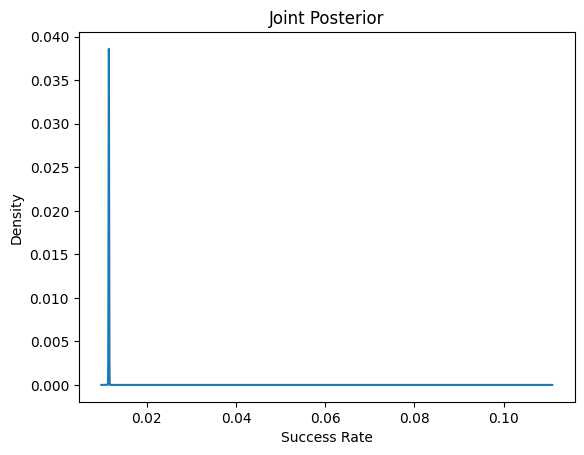

In [19]:
plot_dist(x, y_control * y_treatment, "Joint Posterior")


In [20]:
def plot_dist_with_ci(x, y_list, lower_list, upper_list, title, labels):
    """
    Plots multiple distribution curves with confidence intervals on the same plot.
    
    Parameters:
    x: list or array-like
        The x-values (common for all curves).
    y_list: list of lists or 2D array-like
        A list of y-values for different curves to be plotted.
    lower_list: list or array-like
        A list of lower bounds for the confidence intervals.
    upper_list: list or array-like
        A list of upper bounds for the confidence intervals.
    title: str
        The title of the plot.
    labels: list of str
        Labels for the curves.
    """
    
    for y, lower, upper, label in zip(y_list, lower_list, upper_list, labels):
        plt.plot(x, y, label=label)
        plt.fill_between(x, y, where=(x >= lower) & (x <= upper), alpha=0.3)

    plt.title(title)
    plt.xlabel("Success Rate")
    plt.ylabel("Density")
    plt.legend()  # Add a legend
    plt.xlim([min(lower_list) - 0.1 * abs(min(lower_list)), max(upper_list) + 0.1 * abs(max(upper_list))])
    plt.show()



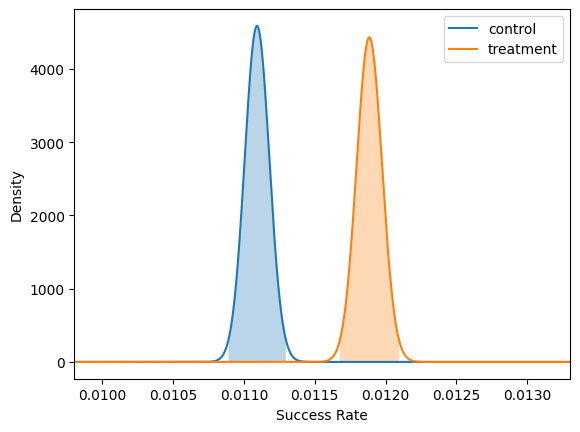

In [21]:
plot_dist_with_ci(x, [y_control, y_treatment], [lower_control, lower_treatment], [upper_control, upper_treatment], title='', labels=['control', 'treatment'])

## Calculating prob. of best arm and loss functions

In this section we go for a numerical integration approach instead of analytical closed solution or Monte Carlo numerical simulations.  

In [22]:
def pdf_treatment(x):
    return stats.beta.pdf(x, alpha_post_treatment, beta_post_treatment)

def pdf_control(x):
    return stats.beta.pdf(x, alpha_post_control, beta_post_control)

# Function to integrate
# For each value of x_treatment, integrate the control's PDF from 0 to x_treatment
def integrand_treatment_times_control(x_control, x_treatment):
    return pdf_control(x_control) * pdf_treatment(x_treatment) 


def loss_function_choose_control(x_control, x_treatment):
    return max(0, x_treatment - x_control) * integrand_treatment_times_control(x_control, x_treatment)

def loss_function_choose_treatment(x_control, x_treatment):
    return max(0, x_control - x_treatment) * integrand_treatment_times_control(x_control, x_treatment)


# Perform the double integration
epsabs = 1e-8
epsrel = 1e-8

x_min = min(lower_control, lower_treatment)
x_min = max(0, x_min - 0.1 * abs(x_min))
x_max = max(upper_control, upper_treatment)
x_max = min(1, x_max + 0.1 * abs(1 - x_max))
# x_min, x_max = 0, 1


In [23]:
prob_treatment_better, _ = dblquad(integrand_treatment_times_control, x_min, x_max, lambda x: x_min, lambda x: x, epsabs=epsabs, epsrel=epsrel)
prob_control_better, _ = dblquad(integrand_treatment_times_control, x_min, x_max, lambda x: x, lambda x: x_max, epsabs=epsabs, epsrel=epsrel)

(prob_treatment_better, prob_control_better)

(0.9999999998831623, 5.261639498407629e-12)

In [24]:
expected_loss_control, _ = dblquad(loss_function_choose_control, x_min, x_max, x_min, x_max, epsabs=epsabs, epsrel=epsrel)
expected_loss_treatment, _ = dblquad(loss_function_choose_treatment, x_min, x_max, x_min, x_max, epsabs=epsabs, epsrel=epsrel)

(expected_loss_control, expected_loss_treatment)

(6.267545583204695e-17, 1.1578126991751642e-67)

Focus on Magnitude vs. Likelihood:

Posterior probability $p(\theta_A > \theta_B)$ only gives a binary comparison: it tells us how likely it is that A is better than B, 
but it ignores the magnitude of the difference.  
It's a qualitative measure of the comparison, however $p(\theta_A > \theta_B)$ might lead to overly simplistic decisions.  
For example, if 
$p(\theta_A > \theta_B)=0.55$ and $p(\theta_B > \theta_A) = 0.45$,
 a decision-maker might be tempted to choose A.  
 However, this doesn't tell us how much better A is likely to be, nor the potential downside of choosing A if B turns out to be better.

In [25]:
print(f"Prob. of treatment being better: {prob_treatment_better:.2%}")
print(f"Prob. of control being better: {prob_control_better:.2%}")
print(f"Error prob. of choosing treatment when control is better: {1 - prob_treatment_better:.2%}")
print(f"Error prob. of choosing control when treatment is better: {1 - prob_control_better:.2%}")

Prob. of treatment being better: 100.00%
Prob. of control being better: 0.00%
Error prob. of choosing treatment when control is better: 0.00%
Error prob. of choosing control when treatment is better: 100.00%


Expected loss, on the other hand, provides a quantitative measure that takes into account the magnitude of the difference between.  
It gives insight into how bad the consequences could be if you make the wrong decision.  
Expected loss integrates over the entire distribution and provides a risk-adjusted decision rule.  
If the difference in expected loss between choosing A or B is large, it signals a stronger preference for one variant.  
If the difference is small, it suggests more uncertainty, and you might want to run the test longer to gather more data.  

Since expected loss is defined on the integral of $(\theta_i - \theta_j)^+$ ($\forall (i,j) \in \lbrace (A, B), (B, A) \rbrace$) times the posterior (a pdf), when assuming on $\theta$ being a conversion rate, then the outcome will be upper bounded to 1.   

In [26]:
print(f"Expected loss for control: {expected_loss_control:.4%}")
print(f'Control Expected loss below threshold: {expected_loss_control < loss_threshold}')
print(f"Expected loss for treatment: {expected_loss_treatment:.4%}")
print(f'Treatment Expected loss below threshold: {expected_loss_treatment < loss_threshold}')

Expected loss for control: 0.0000%
Control Expected loss below threshold: True
Expected loss for treatment: 0.0000%
Treatment Expected loss below threshold: True


Monte Carlo simulations can be useful when analytical solutions are not available or too expensive computationally.  
E.g. computations for tests with more than two arms.